In [3]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 

import tensorflow as tf


## First glance at the data

In [4]:
HOME_DIR = '/Users/uliana/Documents/Coursera/Brain Tumor Auto-Segmentation for Magnetic Resonance Imaging (MRI)/Task10_Colon'
DATA_DIR = HOME_DIR

In [5]:
import os
example_pic = os.path.join(HOME_DIR, 'imagesTr/colon_005.nii.gz')
example_label = os.path.join(HOME_DIR, 'labelsTr/colon_005.nii.gz')

In [6]:
img = nib.load(example_pic)
type(img)

nibabel.nifti1.Nifti1Image

In [7]:
img_data = img.get_fdata()
type(img_data)

numpy.ndarray

In [8]:
img_data.shape

(512, 512, 98)

That is how the MRI data for this task look like (slice across the 3rd dimensioon taken)

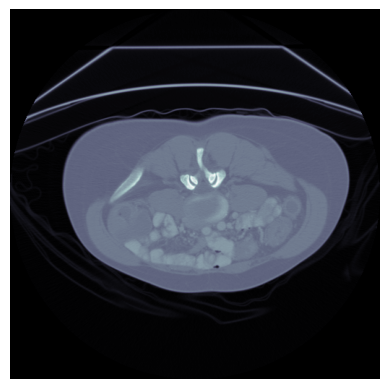

In [10]:
plt.imshow(ndi.rotate(img_data[:,:, 44], 270), cmap='bone')
plt.axis('off')
plt.show()

In [11]:
label = nib.load(example_label)
type(label)

nibabel.nifti1.Nifti1Image

In [12]:
label_data = label.get_fdata()
type(label_data)

numpy.ndarray

### Visualizing labels

White spot is cancerous area (slice across the 3rd dimensioon taken)

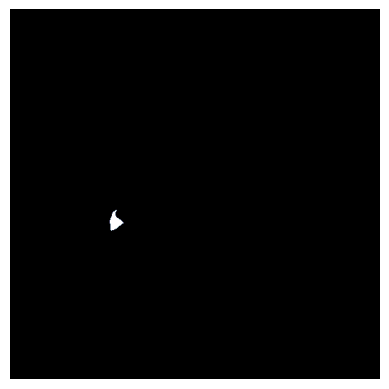

In [13]:
plt.imshow(ndi.rotate(label_data[:,:, 44], 270), cmap='bone')
plt.axis('off')
plt.show()

### Lokalizing cancer on an MRI image

### TBD: add 3d gif of the colon

We see that cancer mostly localizes in one spot
that is why it is preferable to process the data keeping its volume

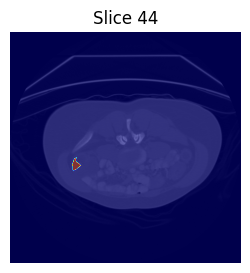

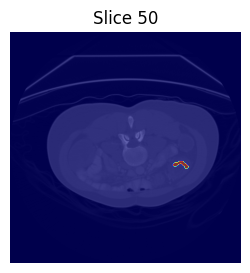

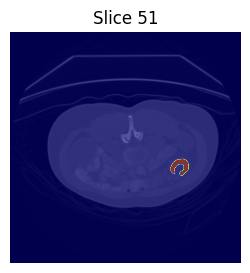

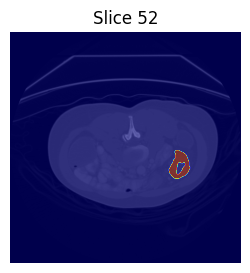

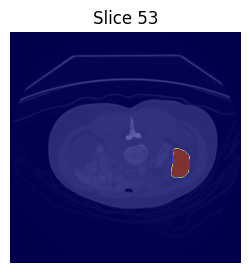

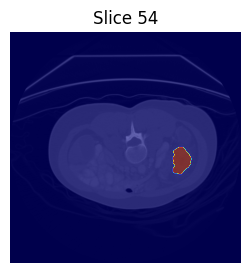

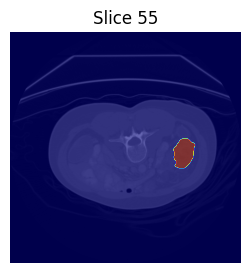

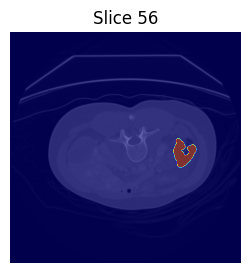

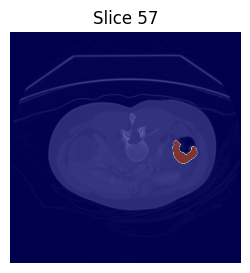

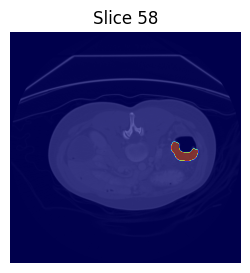

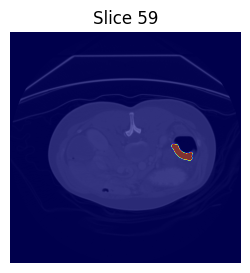

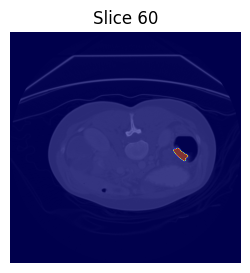

In [14]:
for i in range(98):
    if np.any(label_data[:, :, i] == 1):
        plt.figure(figsize=(3, 3))
        plt.imshow(ndi.rotate(img_data[:,:, i], 270), cmap='gray')
        plt.imshow(ndi.rotate(label_data[:,:, i], 270), cmap='jet', alpha=0.6)
        plt.title(f'Slice {i}')
        plt.axis('off')
    
        plt.show()


## Standartize the data

### Get subvolumes

#### Subvolumes are required due to the limited computational power

Make sure to obtain subvolumes containing at least 5 % of cancerous areas
as the data is highly imbalanced

In [65]:
def get_subvolume(image, label, orig_x=512, orig_y=512, orig_z=98,
                   output_x=160, output_y=160, output_z=8,
                   num_classes=2, max_tries=1000,
                   background_threshold=0.95):

    X = None
    y = None

    tries = 0

    #print(image.shape)
    #print(label.shape)

    while tries < max_tries:
        start_x = np.random.randint(0, orig_x - output_x + 1)
        start_y = np.random.randint(0, orig_y - output_y + 1)
        start_z = np.random.randint(0, orig_z - output_z + 1)

        y = label[start_x: start_x+ output_x,
                start_y: start_y+ output_y,
                start_z: start_z+ output_z
                ]
        
        y = keras.utils.to_categorical(y, num_classes)
        b_ratio = np.sum(y[..., 0]) / (output_x * output_y * output_z)

        tries += 1

        if b_ratio < background_threshold:

            X = np.copy(image[start_x: start_x + output_x,
                                    start_y: start_y + output_y,
                                    start_z: start_z + output_z])
            #print(b_ratio)

            y = np.moveaxis(y, -1, 0)[1:, :, :, :]

            return X, y

  
    print(f"Tried {tries} times to find a sub-volume. Giving up...")
    return X,y

X,y = get_subvolume(image=img_data, label=label_data)

Obtained size of subvolumes 

In [66]:
print(X.shape)
print(y.shape)

(160, 160, 8)
(1, 160, 160, 8)


### Checking subvolumes

Let's look at some of the obtained subvolumes

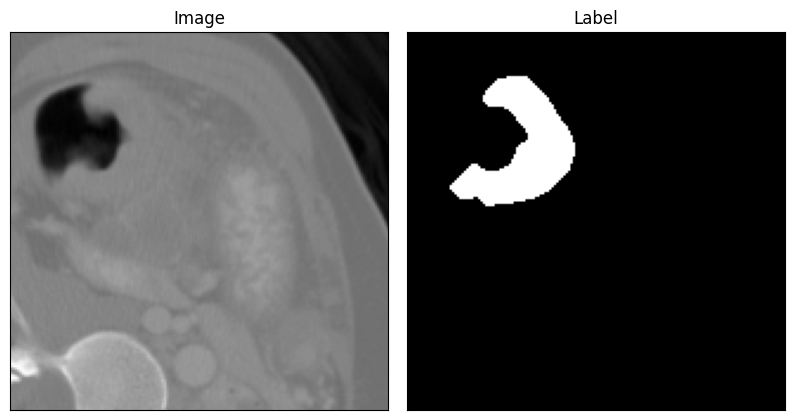

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 10], squeeze=False)

    ax[0][0].imshow(X[:, :, X.shape[2] // 2], cmap='gray')
    ax[0][0].set_title('Image')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    
    ax[0][1].imshow(y[:, :, y.shape[2] // 2], cmap='gray')
    ax[0][1].set_title('Label')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


X, y = get_subvolume(image=img_data, label=label_data)
visualize_patch(X, y[0])


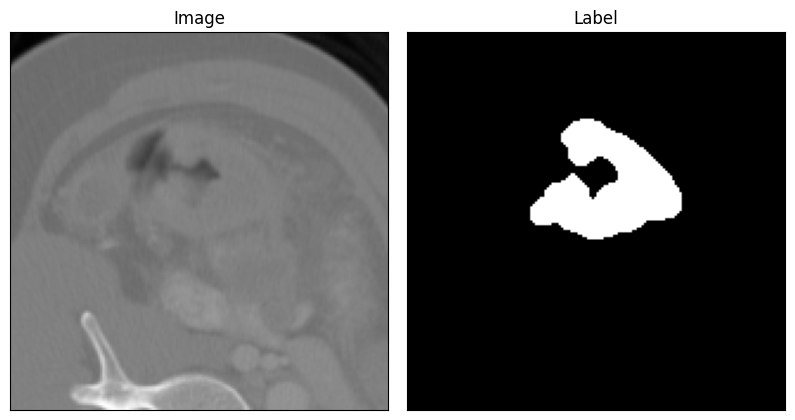

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 10], squeeze=False)

    ax[0][0].imshow(X[:, :, X.shape[2] // 2], cmap='gray')
    ax[0][0].set_title('Image')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    
    ax[0][1].imshow(y[:, :, y.shape[2] // 2], cmap='gray')
    ax[0][1].set_title('Label')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


X, y = get_subvolume(image=img_data, label=label_data)
visualize_patch(X, y[0])


### Standardize the values across a depth dimension to have a mean of zero and standard deviation of 1

In [67]:
def standartize(image):

    standartized_img = np.zeros((image.shape))

    for z in range(image.shape[2]):
        img_slice = image[:,:,z]

        centered = img_slice - np.mean(img_slice)

        if np.std(centered) != 0:
            centered = centered / np.std(centered)

        standartized_img[:,:,z] = centered
    
    return standartized_img

### Check that standartization didn't affect the output

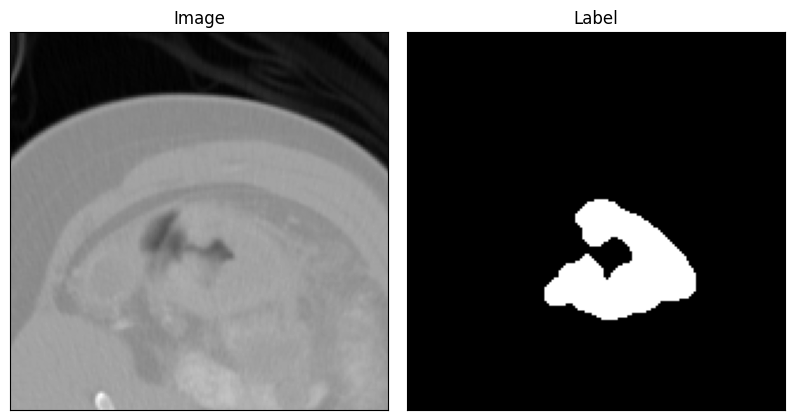

In [68]:
X,y_slice = get_subvolume(img_data, label_data)
X_normalized = standartize(X)
visualize_patch(X_normalized,y_slice[0])

## Initialize evaluation metric and loss

In [45]:
def dice_coefficient(y_true, y_pred, axis=(0, 1, 2), epsilon=0.00001):

    dice_coef = (2 * K.sum(y_pred * y_true, axis = axis) + epsilon) / (K.sum(y_pred, axis = axis) + K.sum(y_true, axis = axis) + epsilon)

    return dice_coef

In [47]:
def soft_dice_loss(y_true, y_pred, axis=(0, 1, 2), epsilon=0.00001):

    dice_loss = 1 - K.mean((2 * K.sum(y_pred * y_true, axis = axis) + epsilon) / (K.sum((y_pred**2), axis) + K.sum((y_true**2), axis) + epsilon))

    return dice_loss

## Initialize the U-Net architecture

In [49]:
from tensorflow.keras.layers import Conv3D, Activation, Conv3DTranspose, BatchNormalization, MaxPooling3D, Add
from tensorflow.keras import Input, Model
from keras.optimizers import Adam

In [75]:
def conv_block(x, filters, kernel_size=(3,3,3), padding='same', activation='relu'):

    x = Conv3D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)

    return x

In [76]:
def upconv_block(x, skip, filters, kernel_size=(2,2,2), strides = (2,2,2), padding='same'):

    x = Conv3DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = Add()([x, skip])

    return x

In [84]:
input_shape=(8,160,160,1)

inputs = Input(input_shape)

In [85]:
c1 = conv_block(inputs, 32)
c2 = conv_block(c1, 64)
p1 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same')(c2)

c3 = conv_block(p1, 64)
c4 = conv_block(c3, 128)
p2 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same')(c4)

c5 = conv_block(p2, 128)
c6 = conv_block(c5, 256)
p3 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same')(c6)

c7 = conv_block(p3, 256)
c8 = conv_block(c7, 512)

up1 = upconv_block(c8, c6, 256)
c9 = conv_block(up1, 256)
c10 = conv_block(c9, 256)

up2 = upconv_block(c10, c4, 128)
c11 = conv_block(up2, 128)
c12 = conv_block(c11, 128)

up3 = upconv_block(c12, c2, 64)
c13 = conv_block(up3, 64)
c14 = conv_block(c13, 64)

c15 = Conv3D(1, kernel_size = (3, 3, 3), padding = 'same', activation = 'sigmoid')(c14)

model = Model(inputs=inputs, outputs=c15)

model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 8, 160,    │          0 │ -                 │
│ (InputLayer)        │ 160, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_239 (Conv3D) │ (None, 8, 160,    │        896 │ input_layer_18[0… │
│                     │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_231      │ (None, 8, 160,    │          0 │ conv3d_239[0][0]  │
│ (Activation)        │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 160,    │        128 │ activation_231[0… │
│ (BatchNormalizatio… │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_240 (Conv3D) │ (None, 8, 160,    │     55,360 │ batch_normalizat… │
│                     │ 160, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_232      │ (None, 8, 160,    │          0 │ conv3d_240[0][0]  │
│ (Activation)        │ 160, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 160,    │        256 │ activation_232[0… │
│ (BatchNormalizatio… │ 160, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_60    │ (None, 4, 80, 80, │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_241 (Conv3D) │ (None, 4, 80, 80, │    110,656 │ max_pooling3d_60… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_233      │ (None, 4, 80, 80, │          0 │ conv3d_241[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 80, 80, │        256 │ activation_233[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_242 (Conv3D) │ (None, 4, 80, 80, │    221,312 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_234      │ (None, 4, 80, 80, │          0 │ conv3d_242[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 80, 80, │        512 │ activation_234[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_61    │ (None, 2, 40, 40, │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_243 (Conv3D) │ (None, 2, 40, 40, │    442,496 │ max_pooling3d_61… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_235      │ (None, 2, 40, 40, │          0 │ conv3d_243[0][0]

 Total params: 13,058,433 (49.81 MB)

 Trainable params: 13,053,761 (49.80 MB)

 Non-trainable params: 4,672 (18.25 KB)